# Using CNN for dolphin whistle classification

Import relevant packages. Set up the virtual environment as specified in the README file to avoid "dependency-hell".

In [40]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models  # For specifying the type of layer (Dense)

# from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report
from pathlib import Path


# Generate Training, Validation and Test Datasets
Before running the following cell, change the relative paths to the folders on your machine.
(Also make sure you have the data on your machine)

In [41]:
TRAINING_DATA_DIR = Path("model_test_train/train")
TEST_DATA_DIR = Path("model_test_train/test")

In [42]:
# These can be configured differently
X, Y = 413, 202
IMAGE_SHAPE = (Y, X) # (row, col) format for imshow and (height, width) for ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, validation_split=0.20
)  # https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, subset="training", shuffle=True, target_size=IMAGE_SHAPE
)

validation_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, subset="validation", shuffle=True, target_size=IMAGE_SHAPE
)

test_generator = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    TEST_DATA_DIR, shuffle=True, target_size=IMAGE_SHAPE
)

Found 1510 images belonging to 3 classes.
Found 377 images belonging to 3 classes.
Found 473 images belonging to 3 classes.


# Visualise the inputs

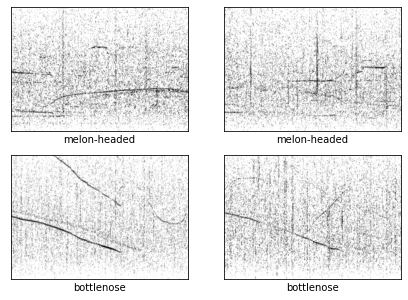

Shape of images:  (32, 202, 413, 3)


In [43]:
# Visualise the datasets
images = iter(train_generator[0][0])
labels = iter(train_generator[0][1])

classes = dict((v, k) for k, v in (train_generator.class_indices).items())

fig, ax = plt.subplots(2, 2, figsize=(7, 5))
for sp in ax.reshape(-1):
    sp.set_xticks([])
    sp.set_yticks([])
    sp.imshow(next(images), aspect="auto")
    label_index = np.where(next(labels) == 1)[0][0]
    sp.set_xlabel(classes.get(label_index))
plt.show()
fig.savefig("image.pdf")
print("Shape of images: ", train_generator[0][0].shape)

# Build a CNN model and stack layers

In [34]:
model = models.Sequential()
KERNEL_SIZE = (3, 3)
INPUT_SHAPE = (X, Y, 3)

model.add(layers.Conv2D(16, KERNEL_SIZE, activation="relu", input_shape=INPUT_SHAPE))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation="relu"))
model.add(BatchNormalization())

# Adding fully connected layers
model.add(layers.Flatten())  # From a 3D tensor to a 1D
model.add(layers.Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(layers.Dense(3, activation="softmax"))

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 411, 200, 16)      448       
                                                                 
 batch_normalization_20 (Bat  (None, 411, 200, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 205, 100, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 203, 98, 16)       2320      
                                                                 
 batch_normalization_21 (Bat  (None, 203, 98, 16)      64        
 chNormalization)                                                
                                                      

# Train the model

In [36]:
# Initialising the model
print("[INFO] compiling model...")
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)  # can play with different parameters

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size
NUM_EPOCHS = 10
es = EarlyStopping("val_loss", mode="min", verbose=1, patience=5)

# Training the network
print("[INFO] training network for {} epochs...".format(NUM_EPOCHS))
history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=NUM_EPOCHS,
    callbacks=[es],
    # validation_split = 0.2,
)


[INFO] compiling model...
[INFO] training network for 10 epochs...
Epoch 1/10
47/47 [==============================] - 46s 960ms/step - loss: 0.0139 - accuracy: 0.9959 - val_loss: 9.1791 - val_accuracy: 0.3153
Epoch 2/10
47/47 [==============================] - 46s 978ms/step - loss: 0.0113 - accuracy: 0.9966 - val_loss: 4.6686 - val_accuracy: 0.4517
Epoch 3/10
47/47 [==============================] - 45s 951ms/step - loss: 0.0058 - accuracy: 0.9980 - val_loss: 3.7031 - val_accuracy: 0.3239
Epoch 4/10
47/47 [==============================] - 45s 948ms/step - loss: 0.0115 - accuracy: 0.9959 - val_loss: 10.6218 - val_accuracy: 0.3210
Epoch 5/10
47/47 [==============================] - 44s 943ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 49.0242 - val_accuracy: 0.2301
Epoch 6/10
47/47 [==============================] - 45s 947ms/step - loss: 0.0052 - accuracy: 0.9993 - val_loss: 34.9492 - val_accuracy: 0.2330
Epoch 7/10
47/47 [==============================] - 45s 944ms/step - los

# Evaluating the Network

**Validation and training accuracy:**

[INFO] evaluating network...
15/15 - 4s - loss: 0.0112 - accuracy: 0.9958 - 4s/epoch - 260ms/step
----- Evaluation Summary statistics -----
Test accuracy =  0.9957716464996338
Test loss =  0.011180789209902287


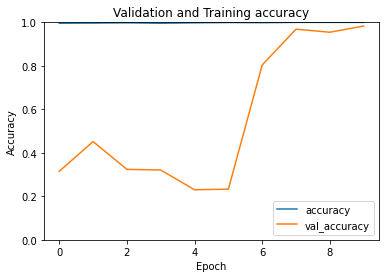

In [37]:
# Evalutate the network - use validation set
print("[INFO] evaluating network...")

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.title("Validation and Training accuracy")
plt.legend(loc="lower right")

test_loss, test_acc = model.evaluate(
    test_generator, verbose=2
)  # Check the return values for this

# SUMMARY STATISTICS
print("----- Evaluation Summary statistics -----")
print("Test accuracy = ", test_acc)
print("Test loss = ", test_loss)


**Validation and Training Loss:**

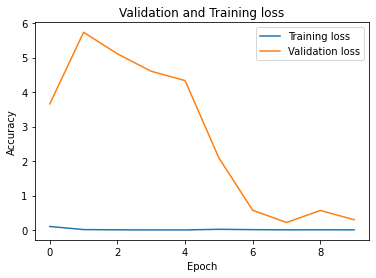

In [22]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.title("Validation and Training loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# plt.ylim([0, 1])
plt.legend()


In [38]:
print("[INFO] Predict with network...")
model = keras.models.load_model("10_02_2022_basic_classifier.model")
test_generator.reset()
test_labels = test_generator.classes
array_of_class_names = np.array(list(classes.values()))
y_hat = model.predict(test_generator)
print(
    classification_report(
        test_labels, y_hat.argmax(axis=1), target_names=array_of_class_names
    )
)


[INFO] Predict with network...


OSError: No file or directory found at 10_02_2022_basic_classifier.model

# Save or load model

In [39]:
# Save the trained model -> could save just the weights or the entire architecture
model.save('25-03-2022-basic-classifier.model')
# loaded_model = keras.models.load_model('/content/drive/MyDrive/16_03_2021_basic_classifier.model')

2022-03-25 11:08:38.446342: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: 25-03-2022-basic-classifier.model/assets
